# 2D Capillary Rise

0.0008394685149335336
['/home/asghar/Downloads/wettingTestCases/argoCases/2DCapillaryRiseTest/test_00000_case/postProcessing/height.csv', '/home/asghar/Downloads/wettingTestCases/argoCases/2DCapillaryRiseTest/test_00006_case/postProcessing/height.csv', '/home/asghar/Downloads/wettingTestCases/argoCases/2DCapillaryRiseTest/test_00012_case/postProcessing/height.csv', '/home/asghar/Downloads/wettingTestCases/argoCases/2DCapillaryRiseTest/test_00018_case/postProcessing/height.csv', '/home/asghar/Downloads/wettingTestCases/argoCases/2DCapillaryRiseTest/test_00024_case/postProcessing/height.csv']


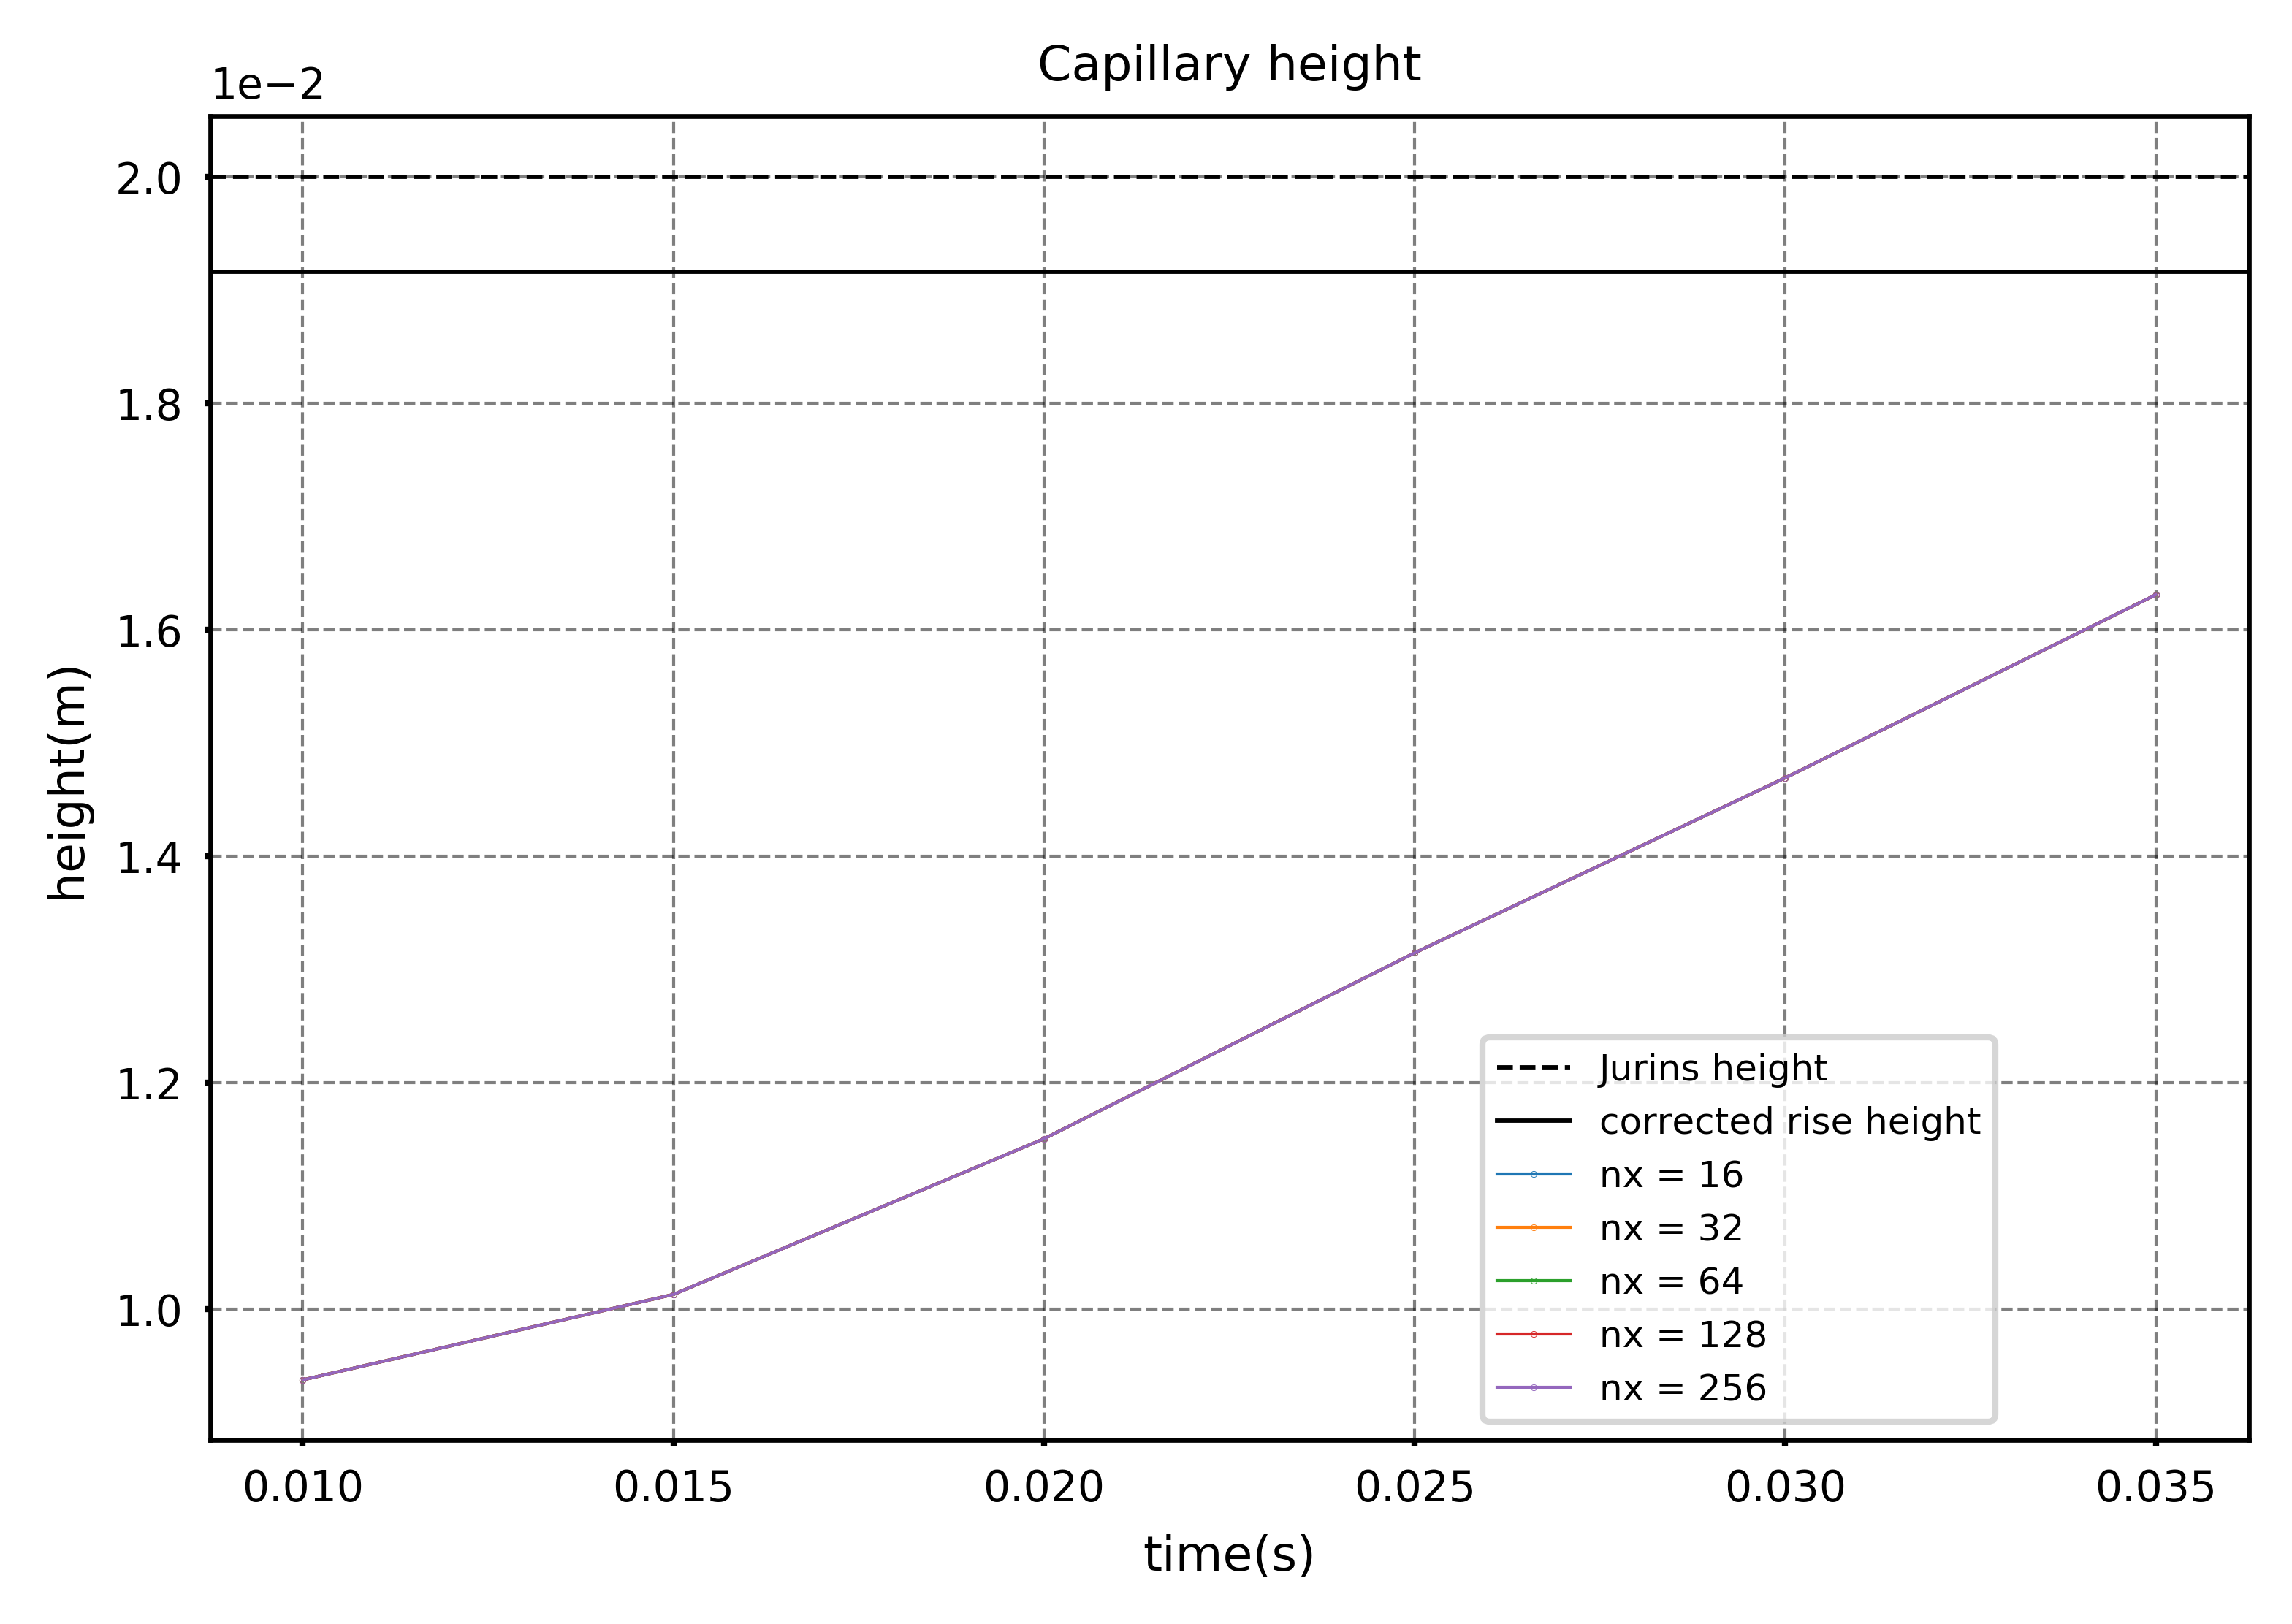

In [4]:
import numpy as np
from scipy.optimize import fsolve
import math
import sys
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os
import csv
import pandas as pd

sin =np.sin
cos= np.cos
pi = np.pi
contact_angle =30
theta =np.deg2rad(contact_angle)
R0 = 0.005
eps = 1e-10

##################################################################################################################

#Reference solution
#Jurin's height 
h_j=4*R0
#Height correction  (2-sin(30) - arcsin(cos(30)) /cos(30))
h_cap = (R0/2/math.cos(theta))  * (2-sin(theta) - (math.asin(cos(theta)) /cos(theta)))
print(h_cap)
#stationary rise height
h_apex = h_j-h_cap

#Reference solution line
plt.axhline(h_j, color='black', linewidth=0.7,linestyle='dashed', label = "Jurins height")
#Reference solution line
plt.axhline(h_apex, color='black', linewidth=0.7, label = "corrected rise height")

###################################################################################################################
## Simulation Results

def fileStructure(dataFile):
    #File structure    
    pattern = "test_"
    dataFolder = "/postProcessing/"
    dataFile = dataFile
    cwd = os.getcwd()
    casefolders = [cwd + "/" + folder for folder in os.listdir(cwd) if pattern in folder]    
    datafolders = [df+dataFolder for df in casefolders]
    datafolders.sort()
    fileNames = [fN+dataFile for fN in datafolders]
    return(fileNames)   

##################################################################################################################
class height_vector:
    x_coord = 0.0
    y_coord = 0.0
    z_coord = 0.0
    

vtk_folders = fileStructure('surfaces/')
heightFileNames = fileStructure('height.csv')
print(heightFileNames)

#fig = plt.figure()
#myaxes = fig.add_axes([0.1, 0.1, 0.45, 0.4])
rcParams["figure.dpi"] = 600
plotLabels = ["numerical capilary height"]

##################################################################################################################

# Height of the droplet at a specific time step Plots
import vtk
#location of vtk files
def writeHeightFile(calcHeights):
    if(calcHeights):
        for idx, vtk_folder in enumerate(vtk_folders):
            #getting the time step folder names
            sub_folders = [name for name in os.listdir(vtk_folder) if os.path.isdir(os.path.join(vtk_folder, name))]
            sub_folders.sort()

            #file-content
           # header = ['Time(s)', 'Height(m)']
            with open(heightFileNames[idx], 'w') as f:
                writer = csv.writer(f)

            for sub_folder in sub_folders:
                heightObject = height_vector()
                heightObject.z_coord = 0
                numberOfCoordinates = 0.0
                ifCoordArray = 0 # just to take POINTS array
                counter =0
                with open(vtk_folder + sub_folder +"/isoAlpha.vtk") as reader:
                    for line in reader:
                        if "POINTS" in line: #start of coordinates
                            breakUp = line.split()
                            numberOfCoordinates = int(breakUp[1])
                            ifCoordArray = 1;

                        elif "\n" not in line[0] and ifCoordArray ==1 and "POINTS" not in line:
                            coordBreakUp = line.split()
                            coordPerLine = int(len(coordBreakUp) / 3)
                            if (counter ==0):
                                heightObject.z_coord = float (coordBreakUp[1])
                                counter =1
                            if(counter==1):
                            #check on Z coordinate
                                for i in range(0, coordPerLine):
                                    coordinateIndex = ((int(len(coordBreakUp)-1)%3)-1) + (i*3)
                                    heightObject.z_coord = min (heightObject.z_coord, float(coordBreakUp[coordinateIndex]))

                        if "\n" in line[0] and ifCoordArray ==1:
                            ifCoordArray =2

                data_to_write_to_csv = [sub_folder, str(heightObject.z_coord)]
                
                with open(heightFileNames[idx], 'a') as f:
                    writer = csv.writer(f)
                    writer.writerow(data_to_write_to_csv)

###############################################################################################################

calcHeights = True
writeHeightFile(calcHeights)

#Plot equilibrium spread against static contact angle

cellsPerRadius=[16, 32, 64, 128, 256] #cells per radius for the simulaitons

for idx, heightFile in enumerate(heightFileNames):

    ### Read .csv file and append to list
    pd.set_option('display.float_format', lambda x: '%.1f' % x)
    df = pd.read_csv(heightFile, index_col = 0)

    ### Create plot for every file  
    plt.plot(df, linewidth=0.5, label='nx = ' + str(cellsPerRadius[idx]), marker='o', markersize=0.1)
    
    #major grid lines
    plt.grid(b=True, which='major', color='black',linestyle='dashed', alpha=0.5, lw=0.5)
    #minor grid lines
    plt.grid(b=True, which='minor', color='black', alpha=0.5, lw=0.5)
    plt.tick_params(axis='both', direction='out', length=1, width=1,  grid_color='black', grid_alpha=0.5)
    plt.title('Capillary height', fontsize=8)
    plt.xlabel("time(s)" ,color='black',fontsize=8)
    plt.ylabel("height(m)",color='black',fontsize=8)
    plt.legend(loc='lower center', bbox_to_anchor=(0.75, 0), ncol=1, fontsize=6)
    plt.xticks(color='black',size = 7)
    plt.yticks(color='black',size = 7)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.rc('font', size=7)

    
## Generate the plot
#plt.savefig('plots/Droplet interface Height'+'.pdf')
#plt.savefig('capillary-rise-convergence-study'+'.png', bbox_inches='tight')
plt.show()
#######################################################################################
